# Element Parameter Detection

## Setup

In [2]:
import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src. preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune
from tqdm.notebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
random.seed = 42

In [4]:
#path = Path("ModelNet10")
#path = Path('/content/drive/MyDrive/ElementNet/')
path = Path('output/')
#savepath = '/content/drive/MyDrive/ElementNet/'
savepath = 'models/'

## Model

## Test

Analyze results statistically

POINTNET++

In [5]:
train_transforms = transforms.Compose([
                    Normalize(),
#                    RandomNoise(),
                    ToTensor()
                    ])

In [43]:
# load data and model
BASE_DIR = os.path.dirname(os.path.abspath('industrial-facility-relationships/'))
BASE_DIR = os.path.join(BASE_DIR, 'pointnet2')
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'models'))
inference = True
if inference:
    path = Path('output/bp_data/')
    ext = ".ply"
#     path = Path('tee_fix/')
#     ext = ".pcd"
else:
    path = Path('output/')
    ext = ".pcd"

cat= 'tee'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_normals = False
cat_targets = {"elbow":14, "tee":19, "pipe":11}

if inference:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms, inference=True)
    targets = cat_targets[cat]
else:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms)
    targets = test_ds.targets

testDataLoader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32)
test_criterion = nn.MSELoss()

model_name = "pointnet2_cls_ssg"
model_path = Path("pointnet2/log/classification/pointnet2_cls_ssg/")
model = importlib.import_module(model_name)


predictor = model.get_model(targets, normal_channel=use_normals)
if device != "cpu":
    predictor = predictor.cuda()

checkpoint = torch.load(model_path/'checkpoints/best_model.pth')
#checkpoint = torch.load(model_path/'checkpoints/models/best_model_t_chamfer_0005.pth')
predictor.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [44]:
blueprint = 'data/sample.ifc'
temp_dir = "output/temp/"
target_dir = "output/tee/test/"

ifcConvert_executable = "scripts/./IfcConvert"
cloudCompare_executable = "cloudcompare.CloudCompare"
sample_size = 2048
threshold = 2

In [45]:
def model_inference(model, loader, device, calculate_score=False):
    predictor = model.eval()
    predictions_list, pcd_list, id_list = [], [], []
    with torch.no_grad():
        for j, data  in tqdm(enumerate(loader), total=len(loader)):
            points, ids = data['pointcloud'].to(device).float(), data['id'].to(device)
            points = points.transpose(2, 1)
            preds, _ = predictor(points)
            preds, points, ids = preds.to(torch.device('cpu')), points.to(torch.device('cpu')), data['id'].to(torch.device('cpu'))
            for i, pr in enumerate(preds):
                predictions_list.append(pr.numpy())
                pcd_list.append(points[i].numpy())
                id_list.append(ids[i].numpy())

        return (predictions_list, pcd_list, id_list)

In [46]:
if inference:
    predictions_list, cloud_list, id_list = model_inference(predictor.eval(), testDataLoader, device)

  0%|          | 0/28 [00:00<?, ?it/s]

In [47]:
def test(model, loader, device, criterion):
    losses = []
    predictor = model.eval()
    cloud_list = []
    label_list = []
    output_list = []
    predictions_list = []
    inputs_list = []
    id_list = []
    parameter_id = 0
    tot = 0
    count = 0
    
    for j, data  in tqdm(enumerate(loader), total=len(loader)):
        inputs, labels, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points, target, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device('cpu'))
        inputs = points.to(torch.device('cpu'))
        labels = target.to(torch.device('cpu'))
        ids = ids.to(torch.device('cpu'))
        #print(data['pointcloud'].size(), labels.size(), outputs.size())

        for i in range(outputs.size(0)):
            label_list.append(labels[i][parameter_id].item())
            id_list.append(ids[i].item())
            output_list.append(outputs[i][parameter_id].item())
            predictions_list.append(outputs[i].numpy())
            inputs_list.append(labels[i].numpy())
            cloud_list.append(inputs[i].numpy())
            ratio = ((labels[i][parameter_id]-outputs[i][parameter_id])/labels[i][parameter_id]).item()
            #print('r', i+count, ids[i].item(), labels[i][parameter_id].item(), outputs[i][parameter_id].item(), ratio)
            tot += np.absolute(ratio)
            #print('l', labels[i][1].item(), outputs[i][1].item(), ((labels[i][1]-outputs[i][1])/labels[i][1]).item())
        
        count += outputs.size(0)
    print(tot/count)

    return predictions_list, inputs_list, label_list, output_list, id_list, cloud_list

In [48]:
if not inference:
    with torch.no_grad():
        predictions_list, inputs_list, label_list, output_list, id_list, cloud_list = test(predictor.eval(), testDataLoader, device, test_criterion)

    print(len(predictions_list), len(inputs_list))

In [49]:
# k = 5
# j = 4
# direction = False
# use_direction = True
# square_error = True
# error_calc(predictions_list, inputs_list, k, j, direction, use_direction, square_error)

In [50]:
if not inference:
    label_list, output_list, id_list = np.array(label_list), np.array(output_list), np.array(id_list)

In [51]:
# ratio = np.absolute((label_list - output_list)/label_list)
# ratio_ind = ratio.argsort()
# id_list = id_list[ratio_ind]
# print(id_list[-10:-1])

# error_threshold = 0.1
# correct = ratio[np.where(ratio < error_threshold)]
# print(len(ratio), len(correct), len(correct)/len(ratio))


In [52]:
# cloud_id = 2
# pcd_id = 24229  


#### Visually analyse predictions and Fine tune with ICP, calculate chamfer distances

In [53]:
# scaling up and down is required for icp calculations
def chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    error_count = 0

    # get predictions and pcds
    for i in tqdm(range(len(predictions_list))):
    #for i in tqdm(range(50)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)

        try:
            if  icp_correction:
                # note: preds are updated in place during ICP
                _, _ = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                     ifcConvert_executable, cloudCompare_executable, sample_size, threshold, False)

            preds_list.append(preds)
            pcd_list.append(pcd)

        except Exception as e:
            print("ICP error", pcd_id, e)
            error_count += 1

    # calculate chamfer distances
    cuda = torch.device('cuda')    
    rescaled_preds = [scale_preds(preds, cat, up=0) for preds in preds_list]
    preds_t = torch.tensor(rescaled_preds, requires_grad=True, device=cuda)
    cloud_t = torch.tensor(cloud_list, device=cuda)
    
    chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
    chamfer_dists = chamfer_dists.detach().cpu().numpy()
    
#     for i, preds in enumerate(tqdm(preds_list)):
#         preds = scale_preds(preds, cat, up=0)
#         chamfer_distance, _ = get_chamfer_dist_single(pcd_list[i], preds, cat)
#         chamfer_dists.append(chamfer_distance)
        

    
    print("error_count", error_count)
    return chamfer_dists

  0%|          | 0/891 [00:00<?, ?it/s]

error_count 0
avg 132.12733 8 300.33795 26.363283 [0.00257429 0.0024787  0.00243555 0.0024233  0.00241301 0.00239182
 0.00234552 0.00233929 0.0023253  0.0023221  0.00231294 0.00231158
 0.00231047 0.00230314 0.00228212 0.00227544 0.00225906 0.00225757
 0.00224559 0.00223746 0.00223674 0.00223504 0.00222861 0.00221759
 0.00221129 0.00220604 0.00219018 0.00217703 0.00217172 0.00217145
 0.00216957 0.0021604  0.00215833 0.0021565  0.00215188 0.00214991
 0.00213102 0.00212995 0.00212644 0.00212003 0.00211633 0.00211424
 0.00209987 0.0020897  0.00208816 0.00207097 0.00206276 0.00206147
 0.00205764 0.00205424 0.00205036 0.00204371 0.00204281 0.00203771
 0.00202321 0.00201152 0.00200328 0.00199639 0.00199543 0.00198666
 0.0019798  0.00196304 0.00195806 0.00195745 0.00195515 0.00195367
 0.00194949 0.00194879 0.00194396 0.00194237 0.00194054 0.00192819
 0.00191913 0.0019118  0.00190868 0.00190854 0.00188805 0.00188582
 0.00188373 0.00188296 0.0018823  0.00187855 0.0018689  0.00186088
 0.00186009 

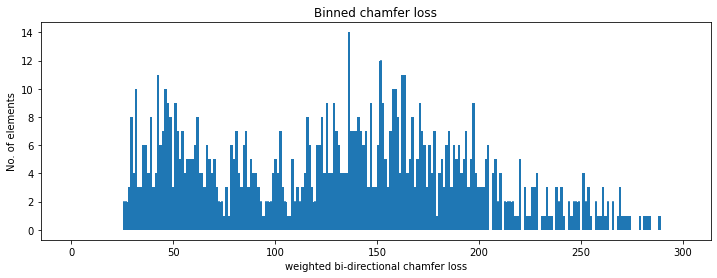

In [54]:
dists = chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
# if inference:
#     with open(model_path + 'preds_' + cat + '.pkl', 'wb') as f:
#         pickle.dump([predictions_list, id_list, dists], f)
    
plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [ ]:
# scaling up and down is required for icp calculations
def _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    viewer_list, ifc_list = [], []
    error_count = 0

    # get predictions and pcds
    #for i in tqdm(range(len(predictions_list))):
    for i in tqdm(range(20)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0).tolist(), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        print(preds)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, ext)

#         try:
        if  icp_correction:
            # note: preds are updated in place during ICP
            viewer, ifc = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                 ifcConvert_executable, cloudCompare_executable, sample_size, threshold, True)
        else:
            #print(preds)
            viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)


        preds_list.append(preds)
        pcd_list.append(pcd)
        viewer_list.append(viewer)
        ifc_list.append(ifc)

#         except Exception as e:
#             print("ICP error", pcd_id, e)
#             error_count += 1


    print("error_count", error_count)    
    return viewer_list

In [ ]:
viewers = _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

In [ ]:
for v in viewers:
    print(v)

In [ ]:
# icp_correction = False
# viewers, ifcs = [], []
# preds_list, pcd_list = [], []

# for i in range(1,4):
#     pcd_id = id_list[i].item()
#     #print(pcd_id) 
        
#     #print("p", predictions_list[i], "in", inputs_list[i])

# #     #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)
# #     pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
# #     print(pcd.shape)
# #     preds = scale_preds(preds.tolist(), cat)
# # #     pcd2, input_preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, path, ext)
# # #     indices_to_replace = [5, 6, 7]
# # #     for i in indices_to_replace:
# # #         preds[i] = input_preds[i]
    
# #     #try:
# #     if not icp_correction:
# #         viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)

# #     else:
# #         viewer, ifc = icp_finetuning(pcd, pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
# #                              ifcConvert_executable, cloudCompare_executable, sample_size, threshold)

# #     viewers.append(viewer) 
# #     ifcs.append(ifc)
# #     preds_list.append(preds)
# #     pcd_list.append(pcd)
       
# # #     except Exception as e:
# # #         print("ICP error", pcd_id, e)
        
#     preds_list.append(inputs_list[i])
#     pcd_list.append(cloud_list[i].transpose(1, 0))

# cloud = o3d.geometry.PointCloud()
# chamfer_dists = []
# for i, preds in enumerate(preds_list):
#     pcd = pcd_list[i]
#     chamfer_distance, cl = get_chamfer_dist_single(pcd, preds, cat)
#     chamfer_dists.append(chamfer_distance)
    
# print("chamfer_distance", sum(chamfer_dists)/len(chamfer_dists))
# print("chamfer_distance", chamfer_dists)
# cloud.points = o3d.utility.Vector3dVector(np.array(cl))
# o3d.io.write_point_cloud("generated.pcd", cloud)
# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pcd.pcd", cloud)


# #tensor based chamfer dist
# preds_tensor = torch.tensor(preds_list).cuda()
# pcd_tensor = torch.transpose(torch.tensor(pcd_list).cuda().float(), 1,2)
# #print(pcd_tensor.shape)
# chamfer_distance = get_chamfer_loss_tensor(preds_tensor, pcd_tensor)
# print("chamfer", chamfer_distance)


# # for i, cl in enumerate(clouds_tensor.detach().cpu().numpy()):
# #     cloud.points = o3d.utility.Vector3dVector(cl)
# #     o3d.io.write_point_cloud("axis_"+str(i)+".pcd", cloud)
# #     cloud.points = pcd_list[i]
# #     o3d.io.write_point_cloud("pcd_"+str(i)+".pcd", cloud)
    
# # cloud = generate_elbow_cloud(preds)
    
# #chamfer_distance = get_chamfer_dist_single(cloud, pcd)
# #print("chamfer_distance", chamfer_distance)




In [ ]:
plot_parameter_errors(inputs_list, predictions_list, cat)

#### BP data Visualisation

In [ ]:
batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

In [ ]:
#merge_clouds(path, 'pipe')

### Misc

In [ ]:
# PCA
#testset_PCA(cloud_list, inputs_list, testDataLoader, cat)

In [ ]:
print(torch. __version__)

In [ ]:
# preds = inputs_list[:512]
# #preds = scale_preds(preds, cat, up=0)
# pcd = cloud_list[1].transpose(1, 0)
# print(preds)

# preds_tensor = torch.tensor(np.array(preds)).cuda().float()
# gen_cloud = generate_tee_cloud_tensor(preds_tensor)
# print(gen_cloud.shape)
# #gen_cloud = generate_pipe_cloud(preds)

# points = gen_cloud.detach().cpu().numpy()
# #points = np.array(gen_cloud)
# cloud = o3d.geometry.PointCloud()
# print(type(points), points.shape)
# cloud.points = o3d.utility.Vector3dVector(points[0])
# #cloud.points = o3d.utility.Vector3dVector(points)
# o3d.io.write_point_cloud("pipe_gen.pcd", cloud)

# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pipe_input.pcd", cloud)

In [ ]:
# chamfer loss
#v, loss = chamfer_fine_tune(50, 0.0001, predictions_list[0], cloud_list[0], cat, blueprint)

In [57]:
limit = 20
#limit = len(predictions_list)

#v, modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=True)
modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=False)


intial loss tensor([228.1048, 129.3526,  50.2754,  48.3813, 231.7801,  44.4189,  86.3737,
        281.5223,  68.0931, 176.0854, 186.8905, 148.0448, 163.1010, 145.0685,
         47.7720, 330.5566, 210.5703, 111.1782, 153.7638, 151.6201],
       device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

0 loss 344.8579
1 loss 314.96805
2 loss 288.2786
3 loss 265.0522
4 loss 244.95743
5 loss 227.6572
6 loss 212.88481
7 loss 200.23648
8 loss 189.55356
9 loss 180.66396
10 loss 173.38995
11 loss 167.27701
12 loss 162.00737
13 loss 157.51678
14 loss 153.44867
15 loss 149.85889
16 loss 146.6578
17 loss 143.67934
18 loss 140.9224
19 loss 138.14403
20 loss 135.36018
21 loss 132.53143
22 loss 129.54173
23 loss 126.541504
24 loss 123.57109
25 loss 120.59803
26 loss 117.83423
27 loss 114.86496
28 loss 112.16374
29 loss 109.59355
30 loss 107.00145
31 loss 104.685135
32 loss 103.5735
33 loss 101.55798
34 loss 99.38999
35 loss 97.24687
36 loss 95.61535
37 loss 94.41524
38 loss 93.556366
39 loss 92.640915
40 loss 91.45833
41 loss 90.18315
42 loss 88.91998
43 loss 87.847305
44 loss 86.96268
45 loss 86.13651
46 loss 85.25565
47 loss 84.3127
48 loss 83.42415
49 loss 82.613785
50 loss 81.73804
51 loss 80.918365
52 loss 80.17949
53 loss 79.5637
54 loss 78.92735
55 loss 78.41681
56 loss 77.85736
57 loss 7

In [58]:
print(v)

NameError: name 'v' is not defined

In [ ]:
plot_parameter_errors(inputs_list, modified_preds, cat)

  0%|          | 0/891 [00:00<?, ?it/s]

error_count 0
avg 33.810837 8 108.46652 7.6387405 [0.00363311 0.00359211 0.00357381 0.00352137 0.0034991  0.00348007
 0.00346481 0.00338977 0.00338644 0.00334303 0.00331662 0.00329557
 0.00328685 0.00325943 0.00322523 0.0032156  0.00319883 0.00319593
 0.00318751 0.00318073 0.00315637 0.00314872 0.00314203 0.00312796
 0.00311093 0.00309839 0.00309786 0.00308914 0.00307956 0.00307854
 0.00307123 0.0030712  0.00306588 0.00304875 0.00304429 0.0030431
 0.00304022 0.00303694 0.00300581 0.00299001 0.00298979 0.00298896
 0.00298178 0.00297972 0.00297247 0.00296732 0.00296108 0.00295738
 0.00295653 0.00295652 0.00295214 0.00294897 0.00294357 0.00293421
 0.0029325  0.00293007 0.00291413 0.00291191 0.00290964 0.00290846
 0.00290053 0.00289499 0.00289498 0.00289235 0.00289175 0.00288838
 0.00288753 0.0028826  0.00288259 0.00287924 0.00287138 0.00286863
 0.00286345 0.00285852 0.00285661 0.00284933 0.00284822 0.00283399
 0.00282932 0.00282005 0.00274614 0.0027155  0.00270841 0.00270335
 0.00270093 0

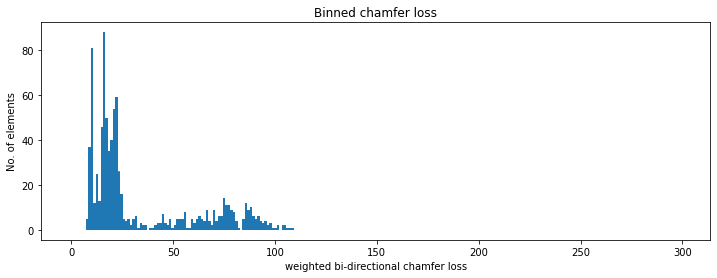

In [56]:
dists = chamfer_evaluate(modified_preds, cloud_list[:limit], id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

if inference:
    with open(model_path/('preds_finetuned_' + cat + '.pkl'), 'wb') as f:
        pickle.dump([modified_preds, id_list, dists], f)

plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [ ]:

# generate points on surface of tee
def generate_tee_cloud(preds):
    # read params
    r1, l1, r2, l2 = abs(preds[0]), preds[1], preds[2], preds[3]
    d1 = get_direction_from_trig(preds, 7)
    d2 = get_direction_from_trig(preds, 13)
    p2 = [preds[4], preds[5], preds[6]]
    p1 = [p2[i] - ((l1*d1[i])/2) for i in range(3)]

    # get new coordinate frame of tee
    old_z = (0., 0., 1.)
    x_axis = vector_normalise(np.cross(d1, old_z))
    y_axis = vector_normalise(np.cross(d1, x_axis))

    # sample points on main tube
    no_of_axis_points = 50    
    no_of_ring_points = 40
    tube1_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r1, l1, p1, d1, x_axis, y_axis)

    # sample points on secondary tube
    x_axis = vector_normalise(np.cross(d2, old_z))
    y_axis = vector_normalise(np.cross(d2, x_axis))   
    tube2_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r2, l2, p2, d2, x_axis, y_axis)

    # remove points from secondary tube in main tube
    tube2_points = np.array(tube2_points)
    p1, p2 = np.array(p1), np.array(p2)
    p2p1 = p2-p1
    p2p1_mag = vector_mag(p2p1)
    tube2_points_ref = []

    for q in tube2_points:
        dist = vector_mag(np.cross((q-p1), (p2p1))) / p2p1_mag
        print(dist, r1)
        if dist > r1:
            print('r', dist)
            tube2_points_ref.append(q.tolist())

    # remove points from main tube in secondary tube
    tube1_points = np.array(tube1_points)
    p3 = np.array(p2 + d2)
    p2p3 = p2-p3
    p2p3_mag = vector_mag(p2p3)
    tube1_points_ref = []

    for q in tube1_points:
        dist = vector_mag(np.cross((q-p3), (p2p3))) / p2p3_mag
        cos_theta = np.dot(q-p2, p2p3)
        if dist > r2 or cos_theta > 0:
            tube1_points_ref.append(q.tolist())

    # make sure not all points are deleted if predictions are very wrong
    thresh = 50
    if len(tube1_points_ref) < thresh and len(tube2_points_ref) < thresh:
        return (tube1_points + tube2_points)
    elif len(tube2_points_ref) < thresh:
        return (tube1_points_ref + tube2_points)
    elif len(tube1_points_ref) < thresh:
        return (tube1_points + tube2_points_ref)
    else:
        return (tube1_points_ref + tube2_points_ref)


In [ ]:
preds = torch.tensor([predictions_list[1]]).cuda()
print(predictions_list[1])
pcd = generate_tee_cloud_tensor(preds)
#tee = generate_tee_cloud(predictions_list[0])
tee = pcd[0].cpu().numpy()
tee = o3d.utility.Vector3dVector(tee)
tee_cloud = o3d.geometry.PointCloud()
tee_cloud.points = tee
o3d.io.write_point_cloud("tee_cl.pcd", tee_cloud)


In [ ]:
original = cloud_list[2]
points= o3d.utility.Vector3dVector(original.transpose(1,0))
tee_cloud.points = points
o3d.io.write_point_cloud("tee_cl_inp.pcd", tee_cloud)

In [ ]:
# undo normalisation opf the bp tee dataset created for inference, only for comparison with the inferred tee results
tee_path = 'tee_fix/tee/test/'
metadata_file = open("tee_fix/tee/metadata.json", 'r')
metadata = json.load(metadata_file)
output_path = 'tee_fix/tee/unnormalised/'

files = os.listdir(tee_path)
new_points = []
for f in tqdm(files):
    cloud_data = metadata[f.split(".")[0]]
    points = np.array(o3d.io.read_point_cloud(tee_path + f).points)
    print("a", points[0])
    print(cloud_data["norm_factor"], cloud_data["mean"])
    points *= cloud_data["norm_factor"]
    print("b", points[0])

    for i, pnt in enumerate(points):
        pnt += cloud_data["mean"]
    print("c", points[10])
    new_points.append(points)
        
new_points = o3d.utility.Vector3dVector(np.concatenate(new_points))
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud(output_path+"tee_bp_unnormalised.pcd", new_cloud)

## Mesh deformation